# Introducing Logistic Falkon

## Introduction

In this notebook we use a synthetic dataset to show how the `LogisticFalkon` estimator works.

We compare Falkon -- which is trained on the squared loss -- to its logistic loss version, and verify that on a binary classification problem logistic falkon achieves better accuracy.

In [1]:
%matplotlib inline
from sklearn import datasets, model_selection
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import falkon

## Load the data

We use a synthetic dataset in two dimensions, which consists of two concentric circles labeled with different classes.

We introduce quite a bit of noise so that the estimators will not trivially achieve zero error, and we draw 100000 samples to demonstrate the speed of the `Falkon` library.

In [2]:
X, Y = datasets.make_circles(
    n_samples=100_000, shuffle=False, noise=0.1, random_state=122)

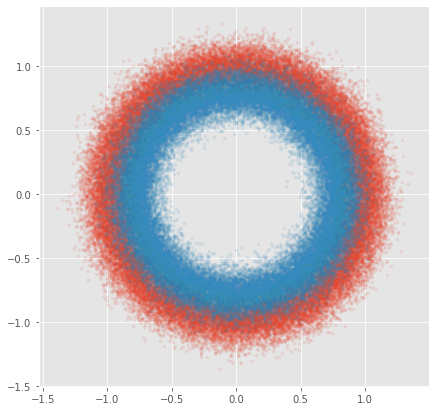

In [3]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[Y == 0,0], X[Y == 0,1], alpha=0.1, marker='.')
_ = ax.scatter(X[Y == 1,0], X[Y == 1,1], alpha=0.1, marker='.')

## Split into training and test sets

We split the data into a training set with 80% of the samples and a test set with the remaining 20%.

In [4]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, test_size=0.2, random_state=10, shuffle=True)

## Data Preprocessing

The minimal preprocessing steps are:
 1. Convert from numpy arrays to torch tensors
 2. Convert data and labels to the same data-type (in this case float32)
 3. Reshape the labels so that they have two dimensions. This is not strictly necessary, but Falkon internally works with 2D tensors, so the output of the `Falkon.predict` method will always be 2D.
 4. Change the labels from 0, 1 to -1, 1. Note that Logistic Falkon uses the following formula for the logistic loss:
     $$\log(1 + e^{-y_1 y_2})$$
     
     where $y_1$ and $y_2$ are labels and predictions respectively, which only makes sense if the labels are -1, 1.

In [5]:
X_train = torch.from_numpy(X_train).to(dtype=torch.float32)
X_test = torch.from_numpy(X_test).to(dtype=torch.float32)
Y_train = torch.from_numpy(Y_train).to(dtype=torch.float32).reshape(-1, 1)
Y_test = torch.from_numpy(Y_test).to(dtype=torch.float32).reshape(-1, 1)

In [6]:
Y_train[Y_train == 0] = -1
Y_test[Y_test == 0] = -1

## Define the Falkon model

We use the same base parameters for both models: a small amount of regularization ($10^{-7}$) and a Gaussian kernel with $\sigma = 5$.
The number of inducing points is set to 1000 which is adequate for the problem which is very easy.

In [7]:
def binary_loss(true, pred):
    return torch.mean((true != torch.sign(pred)).to(torch.float32))

In [8]:
flk_kernel = falkon.kernels.GaussianKernel(5)

flk = falkon.Falkon(kernel=flk_kernel, penalty=1e-7, M=1000)

/home/giacomo/Dropbox/unige/falkon/falkon/falkon/utils/switches.py:18: UserWarning: Failed to initialize cuBLAS library; falling back to CPU. Set 'use_cpu' to True to avoid this warning.
Error encountered was cublas library not found
  warnings.warn(get_error_str("cuBLAS", e))


## Define Logistic Falkon model

The logistic Falkon estimator uses the same base parameters as Falkon.

However, instead of specifying a single value for regularization, we need to specify a *regularization path*: a series of decreasing amounts of regularization. 
For each regularization value we also need to specify the *number of iterations* of conjugate gradient descent, which will be performed for that specific regularization value.

We validated empirically on a wide number of binary classification problems that a good scheme to set the regularization path is to use three short (i.e. 3 iterations) runs with increasing regularization, and then a few longer (here we used 8 iterations) runs with the final regularization value (here `1e-7 `, the same as for Falkon).

The `LogisticFalkon` estimator also accepts a mandatory `loss` parameter, which should be set to an instance of the `LogisticLoss` class. While the `LogisticLoss` is the only implemented loss at the moment, the learning algorithm is defined for any *generalized self-concordant* loss, and we plan to extend the library to support more functions.

An additional feature we show here is **error monitoring**: By passing an error function to the estimator (see parameter `error_fn`), the estimator will print the training error at every iteration (how often such prints occur is governed by the `error_every` parameter).
This can be very useful to determine if it is possible to stop training early, and in general to monitor the training process.

In [9]:
logflk_kernel = falkon.kernels.GaussianKernel(5)
logloss = falkon.gsc_losses.LogisticLoss(logflk_kernel)

penalty_list = [1e-3, 1e-5, 1e-7, 1e-7, 1e-7, 1e-7]
iter_list = [3, 3, 3, 8, 8, 8]

logflk = falkon.LogisticFalkon(
    kernel=logflk_kernel, penalty_list=penalty_list, iter_list=iter_list, M=1000, loss=logloss,
    error_fn=binary_loss, error_every=1)

## Train both models

Training Falkon for 20 iterations (default value) takes about 20s on a laptop.

Clearly, since the logistic falkon runs about 33 iterations (the sum of values in `iter_list`), it is necessarily going to be slower. Further, logistic falkon needs to recompute part of the preconditioner at every step of the Newton method leading to further slowdowns.
On the same laptop, the logistic falkon algorithm takes around 50s.

In [10]:
%%time
flk.fit(X_train, Y_train)

CPU times: user 1min 33s, sys: 44 ms, total: 1min 34s
Wall time: 23.5 s


Falkon(M=1000, center_selection=<falkon.center_selection.UniformSel object at 0x7f95bb20c150>, error_every=1, error_fn=None, kernel=GaussianKernel(sigma=5.0), maxiter=20, options=FalkonOptions(keops_acc_dtype='auto', keops_sum_scheme='auto', no_keops=False, chol_force_in_core=False, chol_force_ooc=False, chol_par_blk_multiplier=2, lauum_par_blk_multiplier=8, pc_epsilon_32=1e-05, pc_epsilon_64=1e-13, cpu_preconditioner=False, cg_epsilon_32=1e-07, cg_epsilon_64=1e-15, cg_tolerance=1e-07, cg_full_gradient_every=10, debug=False, use_cpu=False, max_gpu_mem=inf, max_cpu_mem=inf, compute_arch_speed=False, no_single_kernel=True), penalty=1e-07, seed=None)

In [11]:
%%time
logflk.fit(X_train, Y_train)

Iteration 0 - penalty 1.000000e-03 - sub-iterations 3
Iteration   0 - Elapsed 5.26s - training loss 0.6910 - training error 0.2603 
Iteration 1 - penalty 1.000000e-05 - sub-iterations 3
Iteration   1 - Elapsed 10.48s - training loss 0.5643 - training error 0.1617 
Iteration 2 - penalty 1.000000e-07 - sub-iterations 3
Iteration   2 - Elapsed 15.66s - training loss 0.4028 - training error 0.1613 
Iteration 3 - penalty 1.000000e-07 - sub-iterations 8
Iteration   3 - Elapsed 27.41s - training loss 0.3696 - training error 0.1608 
Iteration 4 - penalty 1.000000e-07 - sub-iterations 8
Iteration   4 - Elapsed 39.28s - training loss 0.3647 - training error 0.1606 
Iteration 5 - penalty 1.000000e-07 - sub-iterations 8
Iteration   5 - Elapsed 51.01s - training loss 0.3632 - training error 0.1605 
Iteration   6 - Elapsed 51.01s - training loss 0.3632 - training error 0.1605 
CPU times: user 3min 42s, sys: 144 ms, total: 3min 42s
Wall time: 55.6 s


## Testing

However, the price paid for with a higher training time, leads to lower training error.

We found that, on a variety of binary classification datasets, logistic falkon obtains a slightly lower error than
the vanilla Falkon algorithm.

In [12]:
flk_pred = flk.predict(X_test)
flk_err = binary_loss(Y_test, flk_pred)

logflk_pred = logflk.predict(X_test)
logflk_err = binary_loss(Y_test, logflk_pred)

print("Falkon model          -- Error: %.2f%%" % (flk_err * 100))
print("Logistic Falkon model -- Error: %.2f%%" % (logflk_err * 100))

Falkon model          -- Error: 15.75%
Logistic Falkon model -- Error: 15.66%


# Plot predictions

In the plot we have the outer and inner circles which are correct predictions, and the circles in the middle which are the mispredicted points.
Since we added lots of noise to the dataset, perfect predictions are not possible (there is no clear boundary between the two classes).

Here the error difference between Falkon and Logistic Falkon is very hard to distinguish by eye. However, there may be other applications where a slightly lower classification error is desired.

In [13]:
def plot_predictions(preds, ax):
    ax.scatter(X_test[((Y_test == -1) & (preds.sign() == Y_test)).reshape(-1), 0], 
               X_test[((Y_test == -1) & (preds.sign() == Y_test)).reshape(-1), 1], 
               alpha=0.1, marker='.', color='b')
    ax.scatter(X_test[((Y_test == 1) & (preds.sign() == Y_test)).reshape(-1),0], 
               X_test[((Y_test == 1) & (preds.sign() == Y_test)).reshape(-1),1], 
               alpha=0.1, marker='.', color='r')

    ax.scatter(X_test[((Y_test == -1) & (preds.sign() != Y_test)).reshape(-1), 0], 
               X_test[((Y_test == -1) & (preds.sign() != Y_test)).reshape(-1), 1], 
               alpha=0.2, marker='x', color='b')
    ax.scatter(X_test[((Y_test == 1) & (preds.sign() != Y_test)).reshape(-1),0], 
               X_test[((Y_test == 1) & (preds.sign() != Y_test)).reshape(-1),1], 
               alpha=0.2, marker='x', color='r')

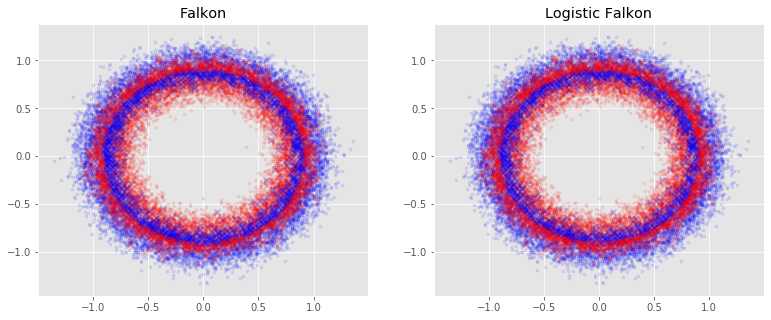

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 5))
plot_predictions(flk_pred, ax[0])
ax[0].set_title("Falkon")
plot_predictions(logflk_pred, ax[1])
_ = ax[1].set_title("Logistic Falkon")